# <font color = gree>PRDL & MLLB courses ETSIT - UPM</font>
> <font color=orange size= 4>Training a Random Forest for Extreme OSA Classification and exploring Features Importance</font>
---


* ### We will use the data in: OSA_extreme_male.xlsx</font>




---
---
Load : OSA_extreme_male.xlsx  from your Laptop



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving OSA_extreme_male.xlsx to OSA_extreme_male.xlsx
User uploaded file "OSA_extreme_male.xlsx" with length 19282 bytes


In [2]:
ls

OSA_extreme_male.xlsx  sample_data/


---

### Read the *OSA_extreme_male.xlsx* file

In [3]:
# Import pandas
import pandas as pd

# Read OSA_DB_UPM.xlsx
df_OSA_male_extreme = pd.read_excel("OSA_extreme_male.xlsx")


In [4]:
df_OSA_male_extreme.head(10)

,Patient,Gender,IAH,Weight,Height,Age,Cervical,OSA,BMI
0,P0005,hombre,9.0,80,173,32,40,Healthy,26.729927
1,P0006,hombre,2.0,109,190,32,42,Healthy,30.193906
2,P0007,hombre,34.0,86,169,39,42,Severe,30.110991
3,P0008,hombre,60.0,145,172,47,44,Severe,49.012980
4,P0013,hombre,3.7,90,180,36,40,Healthy,27.777778
5,P0020,hombre,4.3,89,171,44,45,Healthy,30.436716
6,P0022,hombre,56.0,113,177,33,46,Severe,36.068818
7,P0024,hombre,53.6,107,170,48,46,Severe,37.024221
8,P0025,hombre,2.1,70,174,53,38,Healthy,23.120624
9,P0027,hombre,47.0,100,180,62,48,Severe,30.864198


* # Indicate the features we will use

In [5]:
### Picking predictor columns

# Get all the columns from the dataframe.
columns = df_OSA_male_extreme.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["Patient","Gender","IAH","OSA"]]

# Store the variable we'll be predicting on.
target = "OSA"

print('Predictors: ',columns)

Predictors:  ['Weight', 'Height', 'Age', 'Cervical', 'BMI']


## We will use data (our features) as Numpy arrays

In [6]:
import numpy as np

X = np.array(df_OSA_male_extreme[columns])


In [7]:
X.shape

(278, 5)

# The outcome "y" will have two values: binary classification

* # we can map "Healthy" to "0" and "Severe" to "1"

In [8]:
df_OSA_male_extreme.OSA = df_OSA_male_extreme.OSA.map({'Healthy': 0, 'Severe': 1})

In [9]:
df_OSA_male_extreme.head()

,Patient,Gender,IAH,Weight,Height,Age,Cervical,OSA,BMI
0,P0005,hombre,9.0,80,173,32,40,0,26.729927
1,P0006,hombre,2.0,109,190,32,42,0,30.193906
2,P0007,hombre,34.0,86,169,39,42,1,30.110991
3,P0008,hombre,60.0,145,172,47,44,1,49.012980
4,P0013,hombre,3.7,90,180,36,40,0,27.777778


In [10]:
y = np.array(df_OSA_male_extreme['OSA'])

## Now we train a Random Forest using Nested or Double Loop Crossvalidation

In [11]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
	# split data
	X_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]
	# configure the cross-validation procedure
	cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
	# define the model
	model = RandomForestClassifier(random_state=1)
	# define search space
	space = dict()
	space['n_estimators'] = [100, 250, 500, 600]
	space['max_features'] = [2, 3, 4]
	# define search
	search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
	# execute search
	result = search.fit(X_train, y_train)
	# get the best performing model fit on the whole training set
	best_model = result.best_estimator_
	# evaluate model on the hold out dataset
	yhat = best_model.predict(X_test)
	# evaluate the model
	acc = accuracy_score(y_test, yhat)
	# store the result
	outer_results.append(acc)
	# report progress
	print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>acc=0.571, est=0.744, cfg={'max_features': 3, 'n_estimators': 500}
>acc=0.750, est=0.696, cfg={'max_features': 3, 'n_estimators': 500}
>acc=0.643, est=0.716, cfg={'max_features': 3, 'n_estimators': 100}
>acc=0.714, est=0.752, cfg={'max_features': 2, 'n_estimators': 250}
>acc=0.786, est=0.728, cfg={'max_features': 4, 'n_estimators': 100}
>acc=0.821, est=0.732, cfg={'max_features': 2, 'n_estimators': 250}
>acc=0.679, est=0.736, cfg={'max_features': 3, 'n_estimators': 100}
>acc=0.643, est=0.760, cfg={'max_features': 2, 'n_estimators': 250}
>acc=0.852, est=0.670, cfg={'max_features': 4, 'n_estimators': 100}
>acc=0.667, est=0.709, cfg={'max_features': 3, 'n_estimators': 500}
Accuracy: 0.713 (0.084)


## We train a Random Forest with "best hyperparameters" using ALL data? (discuss!)

In [22]:
from sklearn.model_selection import train_test_split

# define the model
forest = RandomForestClassifier(max_features = 3, n_estimators = 500,random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest.fit(X_train, y_train)


RandomForestClassifier(max_features=3, n_estimators=500, random_state=1)

## You can try the different approaches in [Sklearn RF examples](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

* ### Feature importance based on mean decrease in impurity

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

In [23]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.074 seconds


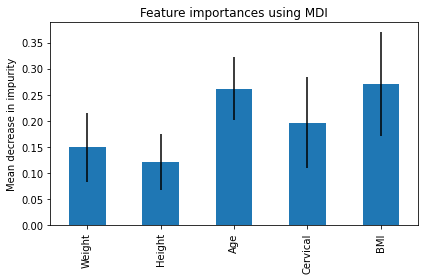

In [24]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

* ## Feature importance based on feature permutation
Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and <font color = red>can be computed on a left-out test set</font>.

Elapsed time to compute the importances: 2.661 seconds


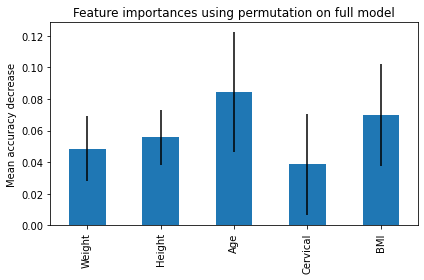

In [25]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()